# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

train_data_dir = '/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/train'
test_data_dir = '/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/test'


Pneumona_img = os.listdir(train_data_dir + "/PNEUMONIA")
Normal_img = os.listdir(train_data_dir + "/NORMAL")
COVID19_img = os.listdir(train_data_dir + "/COVID19")

In [3]:
os.chdir('/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/')

# Import Packages

In [5]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow
import pandas as pd

%matplotlib inline
from glob import glob


# Functions

In [13]:
# Set seed
seed(1)
tensorflow.random.set_seed(2)

In [14]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

In [15]:
model = ResNet50(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
# To Tackle Issue of Imbalanced Dataset during Model Fitting
pneumonia_cases = len(Pneumona_img)
normal_cases = len(Normal_img)
covid_cases = len(COVID19_img)

pneumonia_weight = pneumonia_cases / (pneumonia_cases + normal_cases + covid_cases)
normal_weight = normal_cases / (pneumonia_cases + normal_cases + covid_cases)
covid_weight = covid_cases / (pneumonia_cases + normal_cases + covid_cases)

class_weight = {0: covid_weight, 1: normal_weight,
                2: pneumonia_weight}

print(f"Weight for class 0: {covid_weight:.2f}")
print(f"Weight for class 1: {normal_weight:.2f}")
print(f"Weight for class 2: {pneumonia_weight:.2f}")

Weight for class 0: 0.22
Weight for class 1: 0.21
Weight for class 2: 0.57


Comparing with base model no augmentation of 89.13% train, 90.45% test

# Model with Augmentation (69.25%)

In [ ]:
train_datagen = ImageDataGenerator(
      rescale = 1./255, 
      horizontal_flip=True,
      rotation_range=10,
      zoom_range=0.4)


train_generator =train_datagen.flow_from_directory(
     train_data_dir,
     batch_size= 8,
     seed=42,
     shuffle=True, 
     target_size = (224,224))

test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator =test_datagen.flow_from_directory(
     test_data_dir,
     batch_size= 1,
     seed=42,
     shuffle=False, 
     target_size = (224,224)) 

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
x = Flatten()(model.output)

x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

output = Dense(3, activation='softmax')(x)
model1 = Model(inputs=model.input, outputs=output)

In [ ]:
model1.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
mc = ModelCheckpoint("resnet_model1_withaug.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [ ]:
history1 = model1.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[mc,es],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
755/755 [==============================] - 1765s 2s/step - loss: 0.4370 - accuracy: 0.5904 - val_loss: 0.5157 - val_accuracy: 0.8525

Epoch 00001: val_loss improved from inf to 0.51570, saving model to resnet_model1_withaug.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
755/755 [==============================] - 301s 398ms/step - loss: 0.2348 - accuracy: 0.5980 - val_loss: 0.5451 - val_accuracy: 0.6677

Epoch 00002: val_loss did not improve from 0.51570
Epoch 3/20
755/755 [==============================] - 306s 405ms/step - loss: 0.2304 - accuracy: 0.6106 - val_loss: 0.8381 - val_accuracy: 0.6646

Epoch 00003: val_loss did not improve from 0.51570
Epoch 4/20
755/755 [==============================] - 309s 409ms/step - loss: 0.2285 - accuracy: 0.6191 - val_loss: 0.5942 - val_accuracy: 0.7896

Epoch 00004: val_loss did not improve from 0.51570
Epoch 5/20
755/755 [==============================] - 307s 407ms/step - loss: 0.2106 - accuracy: 0.6380 - val_loss: 0.6266 - val_accuracy: 0.7523

Epoch 00005: val_loss did not improve from 0.51570
Epoch 6/20
755/755 [==============================] - 309s 409ms/step - loss: 0.2140 - accuracy: 0.6352 - val_loss: 0.6117 - val_accuracy: 0.6918

Epoch 00006: val_loss did not improve from 0.51570
Epoch 7/20

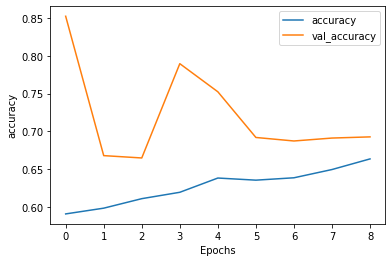

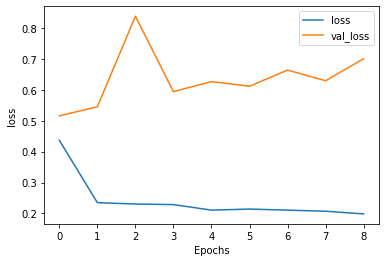

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history1, "accuracy")
plotting(history1, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model1.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model1.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 56s 44ms/step - loss: 0.7006 - accuracy: 0.6925
Test Accuracy: 69.25%
755/755 [==============================] - 260s 344ms/step - loss: 0.9312 - accuracy: 0.6266
Train Accuracy: 62.66%


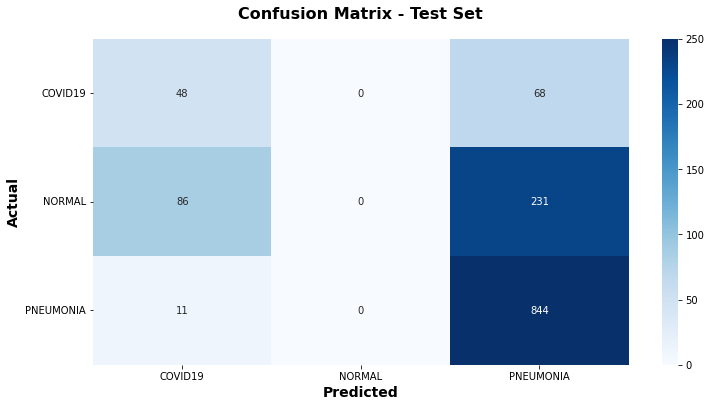

In [ ]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model1.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# Model with Augmentation 2 (92.8%)

In [25]:
train_datagen1 = ImageDataGenerator(
      rescale = 1./255, 
      horizontal_flip=True,
      rotation_range=10,
      zoom_range=0.1)


train_generator1 =train_datagen1.flow_from_directory(
     train_data_dir,
     batch_size= 8,
     seed=42,
     shuffle=True, 
     target_size = (224,224))

test_datagen1 = ImageDataGenerator(
    rescale = 1./255)

test_generator1 =test_datagen1.flow_from_directory(
     test_data_dir,
     batch_size= 1,
     seed=42,
     shuffle=False, 
     target_size = (224,224)) 

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [29]:
x = Flatten()(model.output)

x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

output = Dense(3, activation='softmax')(x)
model2 = Model(inputs=model.input, outputs=output)

In [30]:
model2.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [31]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
mc = ModelCheckpoint("resnet_withaug_model2_.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [32]:
history2 = model2.fit(train_generator1,
                      validation_data=test_generator1,
                      callbacks=[mc,es],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
755/755 [==============================] - 311s 407ms/step - loss: 0.3148 - accuracy: 0.6393 - val_loss: 0.4469 - val_accuracy: 0.7896

Epoch 00001: val_loss improved from inf to 0.44690, saving model to resnet_withaug_model2_.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
755/755 [==============================] - 297s 393ms/step - loss: 0.1725 - accuracy: 0.7151 - val_loss: 0.4384 - val_accuracy: 0.7780

Epoch 00002: val_loss improved from 0.44690 to 0.43840, saving model to resnet_withaug_model2_.h5
Epoch 3/20
755/755 [==============================] - 305s 404ms/step - loss: 0.1427 - accuracy: 0.7641 - val_loss: 0.4803 - val_accuracy: 0.7267

Epoch 00003: val_loss did not improve from 0.43840
Epoch 4/20
755/755 [==============================] - 302s 400ms/step - loss: 0.1221 - accuracy: 0.8062 - val_loss: 0.3684 - val_accuracy: 0.8820

Epoch 00004: val_loss improved from 0.43840 to 0.36844, saving model to resnet_withaug_model2_.h5
Epoch 5/20
755/755 [==============================] - 307s 407ms/step - loss: 0.1198 - accuracy: 0.8168 - val_loss: 0.4614 - val_accuracy: 0.7508

Epoch 00005: val_loss did not improve from 0.36844
Epoch 6/20
755/755 [==============================] - 305s 404ms/step - loss: 0.1222 - accuracy: 0.8175 - val_loss

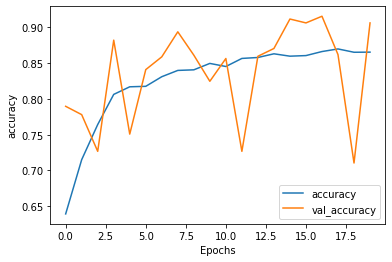

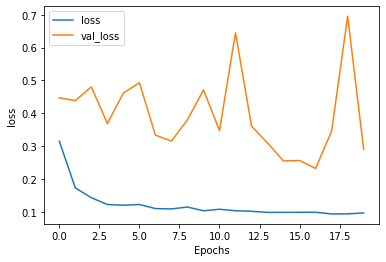

In [33]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history2, "accuracy")
plotting(history2, "loss")

In [34]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model2.evaluate(test_generator1)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model2.evaluate(train_generator1)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 55s 42ms/step - loss: 0.2899 - accuracy: 0.9061
Test Accuracy: 90.61%
755/755 [==============================] - 252s 333ms/step - loss: 0.3363 - accuracy: 0.8754
Train Accuracy: 87.54%


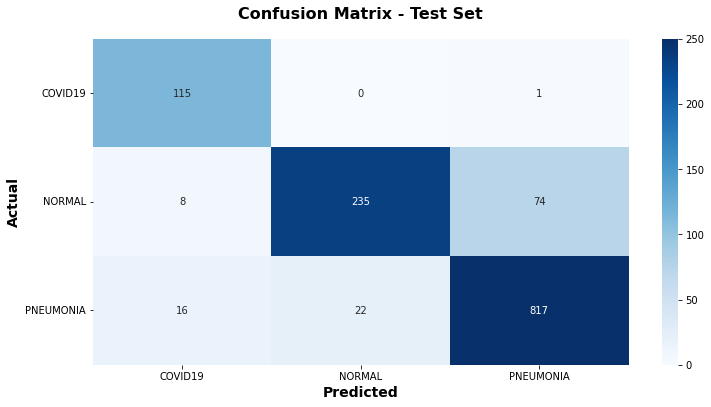

In [35]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model2.predict(test_generator1)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator1.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);